In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import cv2
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf


In [2]:
def build_model(input_shape=(224, 224, 3), num_classes=None):
    """Build the MobileNetV2-based model."""
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)  # Softmax for classification
    model = Model(inputs=base_model.input, outputs=x)

    # Freeze the base model layers for transfer learning
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [3]:
# Directories for training and validation data
train_dir = "/content/drive/MyDrive/smart_vote/dataset/train"
val_dir = "/content/drive/MyDrive/smart_vote/dataset/val"

In [4]:
# Data Augmentation for training images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Rescaling for validation images
val_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# Load the data from the directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'  # Labels are encoded as integers
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

Found 85 images belonging to 4 classes.
Found 11 images belonging to 3 classes.


In [6]:
# Get the number of classes from the training data
num_classes = len(train_generator.class_indices)

In [7]:
# Build the model
model = build_model(num_classes=num_classes)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 3,573,828 (13.63 MB)

 Trainable params: 1,315,844 (5.02 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step - accuracy: 0.2993 - loss: 1.9293 - val_accuracy: 0.2727 - val_loss: 6.3329
Epoch 2/10
1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6562 - loss: 1.2903

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 567ms/step - accuracy: 0.6562 - loss: 1.2903 - val_accuracy: 0.5455 - val_loss: 6.5820
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5833 - loss: 1.2987 - val_accuracy: 0.4545 - val_loss: 7.4837
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 804ms/step - accuracy: 0.7143 - loss: 1.6653 - val_accuracy: 0.2727 - val_loss: 7.7974
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7538 - loss: 1.1514 - val_accuracy: 0.5455 - val_loss: 6.5042
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 502ms/step - accuracy: 0.8750 - loss: 0.5304 - val_accuracy: 0.5455 - val_loss: 5.9739
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.8359 - loss: 0.4439 - val_accuracy: 0.5455 - val_loss: 5.2545
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 505ms/step - accuracy: 0.8750 - loss: 0.4532 - val_accuracy: 0.5455 - val_loss: 4.9942
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9271 - loss: 0.3773 - val_accuracy: 0.5455 - val_loss: 4.6259
Epoch 10/10
2/

In [9]:
# Access the training accuracy from the history object
training_accuracy = history.history['accuracy']  # List of accuracy values for each epoch
print("Training Accuracy Per Epoch:", training_accuracy)

Training Accuracy Per Epoch: [0.3396226465702057, 0.65625, 0.640625, 0.7142857313156128, 0.7735849022865295, 0.875, 0.849056601524353, 0.875, 0.9375, 0.9523809552192688]


In [10]:
# Access the final training accuracy
final_training_accuracy = training_accuracy[-1]  # The accuracy from the last epoch
print(" Training Accuracy:", final_training_accuracy)

 Training Accuracy: 0.9523809552192688


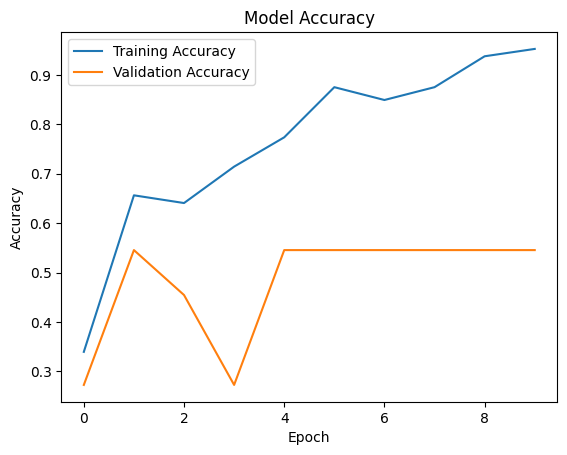

In [11]:
import matplotlib.pyplot as plt

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


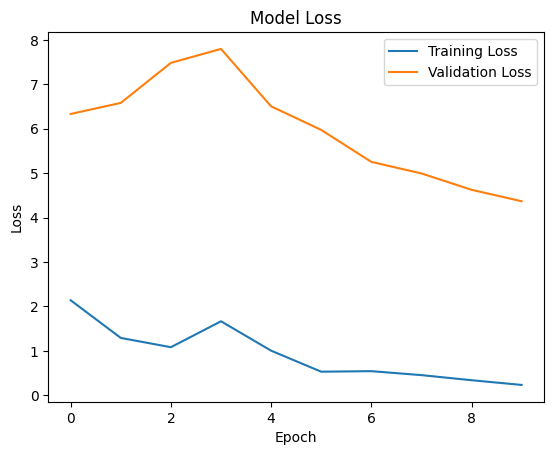

In [12]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# Extract embedding model by accessing the pooling layer directly
embedding_model = Model(inputs=model.input, outputs=model.layers[-3].output)  # Access by layer index

In [14]:

# Example: Using the embedding model
print("Embedding Model Summary:")
embedding_model.summary()

Embedding Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
# Embeddings database with a new 'class_names' list
embeddings_db = {'embeddings': [], 'labels': [], 'class_names': []}


In [16]:
def preprocess_image(image_path, target_size=(224, 224)):
    """Preprocess an image for embedding extraction."""
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalize pixel values
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image


In [17]:
def add_image_to_db(image_path, label):
    """Add new image to the embeddings database."""
    image = preprocess_image(image_path)
    embedding = embedding_model.predict(image)
    embeddings_db['embeddings'].append(embedding[0])
    embeddings_db['labels'].append(label)

    # Add class name to the 'class_names' list
    if label not in embeddings_db.get('class_names', []):
        embeddings_db.setdefault('class_names', []).append(label)

    print(f"Added {label} to database.")


In [18]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recognize_image(image_path, threshold=0.5):
    """Recognize a new image by comparing it with existing embeddings."""
    # Preprocess the image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize

    # Get the embedding of the input image
    embedding = embedding_model.predict(img_array)

    # Calculate similarities with existing embeddings in the database
    similarities = cosine_similarity(embedding, embeddings_db['embeddings'])
    max_index = np.argmax(similarities)
    max_similarity = similarities[0, max_index]

    # Compare the similarity to the threshold
    if max_similarity >= threshold:
        predicted_class = embeddings_db['class_names'][max_index]
        print(f"Image recognized as {predicted_class} with similarity {max_similarity:.2f}")
    else:
        print(f"Image not recognized. Similarity: {max_similarity:.2f}")


In [19]:
# Example Usage
# Add new images dynamically
add_image_to_db('/content/drive/MyDrive/smart_vote/fake/01580625f0c2fe11fb2b7d2bd4b216db.jpeg', 'ragini')
add_image_to_db('/content/drive/MyDrive/smart_vote/fake/0461ffb0079f748659033d42d10e7a0a.jpeg', 'karthik')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Added ragini to database.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Added karthik to database.


In [20]:
# Recognize a new image
recognize_image('/content/drive/MyDrive/smart_vote/dataset/train/karthik/IMG_20170310_185437.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Image recognized as karthik with similarity 0.55


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


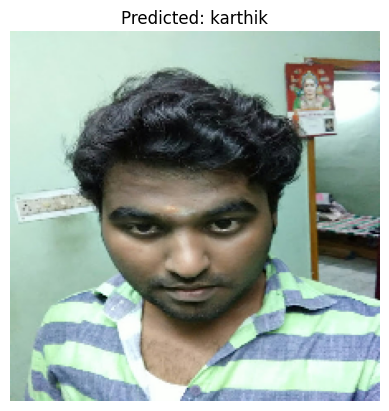

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def display_image_with_prediction(image_path, model, threshold=0.5):
    """Display an image and its predicted class."""
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize the image

    # Get the model's prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Get the class label from the class indices
    class_label = list(train_generator.class_indices.keys())[predicted_class]

    # Plot the image and display the prediction
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.title(f"Predicted: {class_label}")
    plt.show()

# Example Usage
image_path = '/content/drive/MyDrive/smart_vote/dataset/train/karthik/IMG_20170310_185437.jpg'
display_image_with_prediction(image_path, model)
